# Auto-recognize and solve sudoku, Proof of Concept (draft)
In this notebook we will try to:
  *  read a picture of a sudoku puzzle
  *  detect and extract the puzzle
  *  extract the information into a solvable table form
  *  solve the puzzle
  *  present the answer

In [2]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 20,10

## Read and process the image

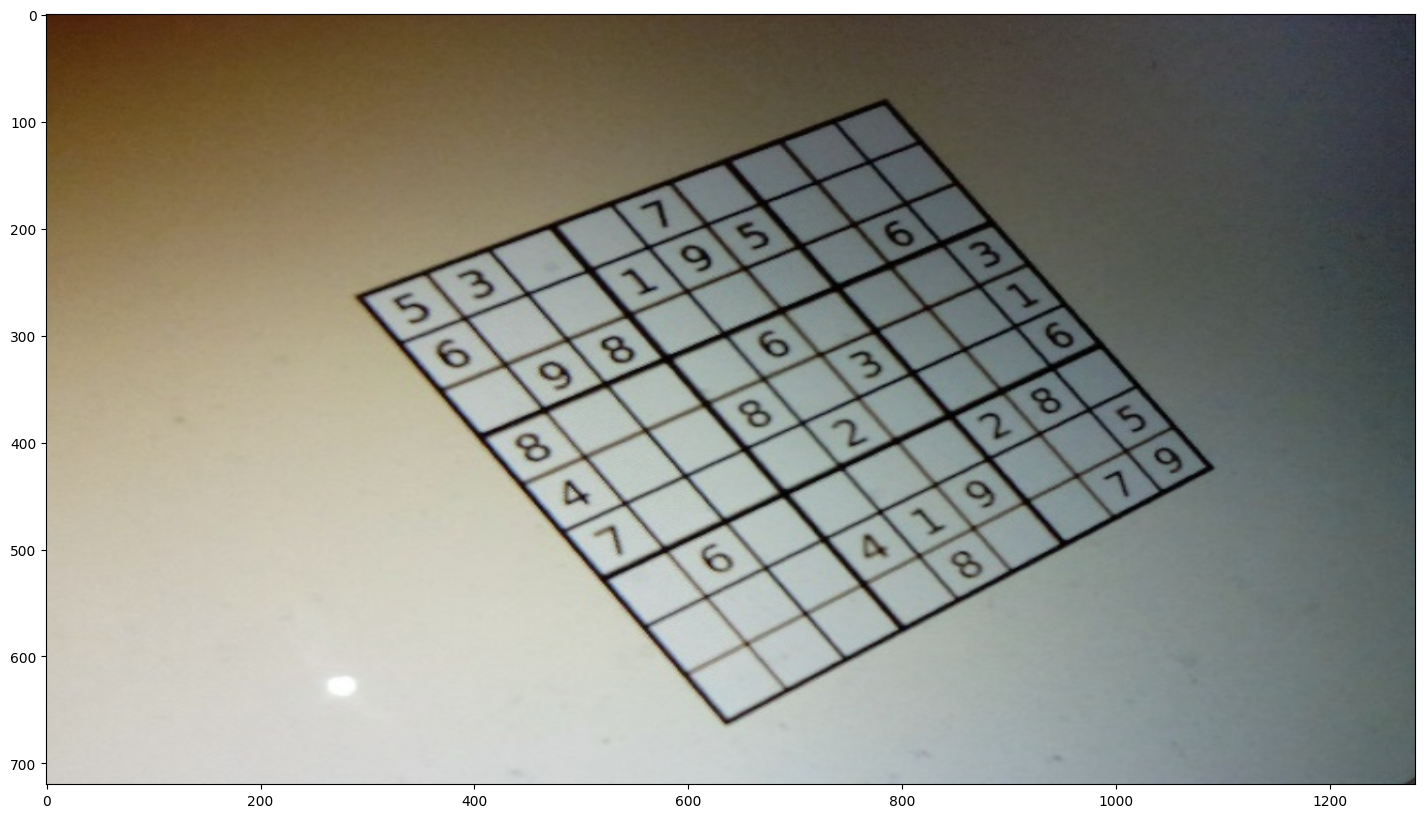

In [83]:
RESOLUTION = (720, 1280)
path = r"./pics/test1.jpg"
rgb = cv2.cvtColor(cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), (RESOLUTION[::-1])), cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

## RGB to Gray
We don't need the color information. Turning the image to grayscale will also make processing easier

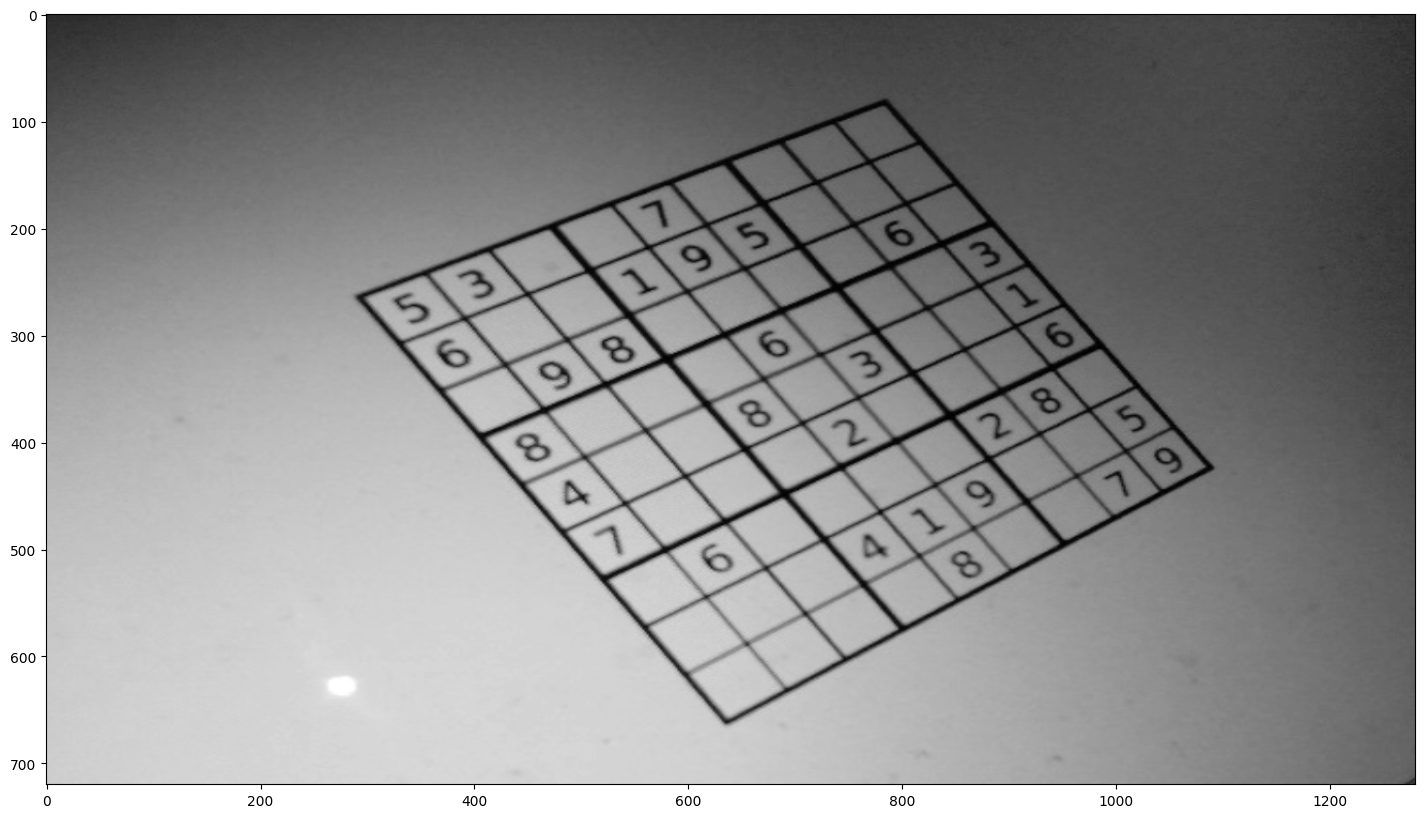

In [144]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

## Gray to Binary
Here we convert the image from grayscale to binary form. We will use **adaptive threshold** technique which applies a **dynamic threshold** that **handles shadows** well. I also inverse the image with a **not operation** t

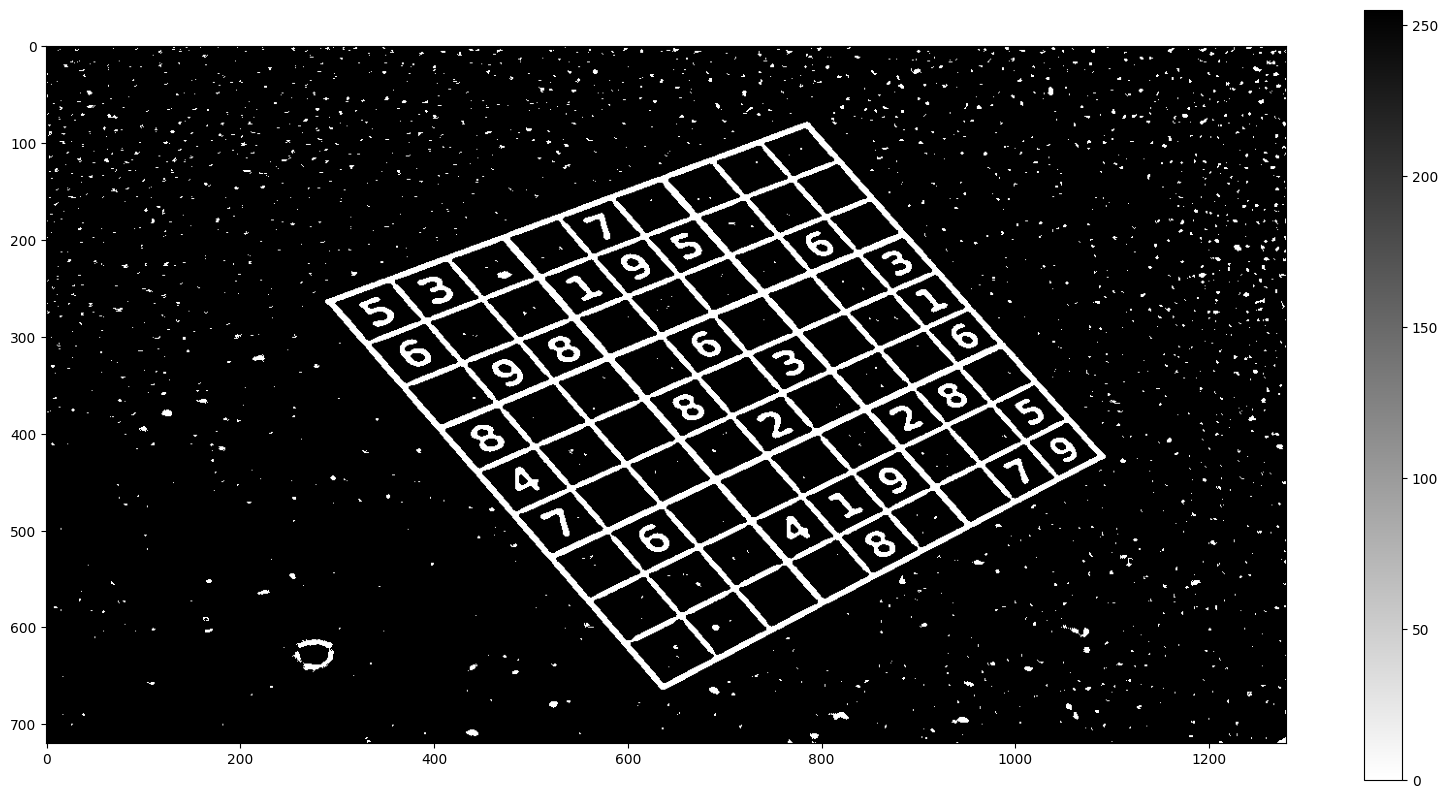

In [145]:
gray_blurred = cv2.GaussianBlur(gray, (7, 7), 1.5)
bin = cv2.adaptiveThreshold(gray_blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(bin, cmap='binary')
plt.colorbar()

# Segmentation
Here we start the segmentation process. Goal is to isolate the important information (the sudoku puzzle) from the noise

## Contours
An easy and fast way of separating the items contained in the image is to find their contours and filter them by their properties.

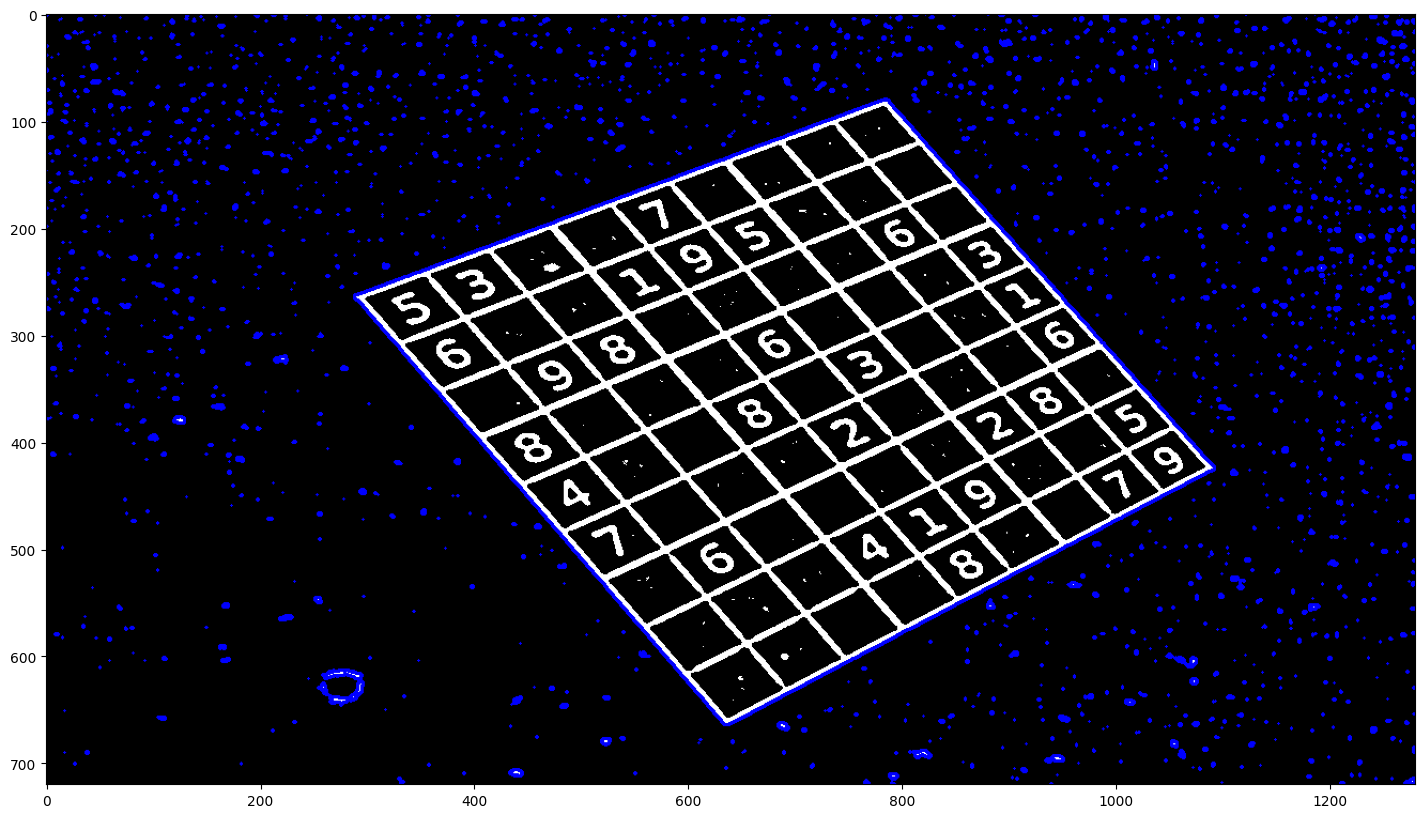

In [146]:
bin_not = cv2.bitwise_not(bin)
contours, hierarchy = cv2.findContours(bin_not, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

display = np.stack([bin_not, bin_not, bin_not], axis=2)
plt.imshow(cv2.drawContours(display, contours, -1, (0, 0, 255), 2))

We can play with properties like area, perimeter or approximate the overall shape. For example, let's check the **surface area** of the picked items.

areas=array([0. , 0. , 2.5, ..., 0. , 0.5, 2. ])


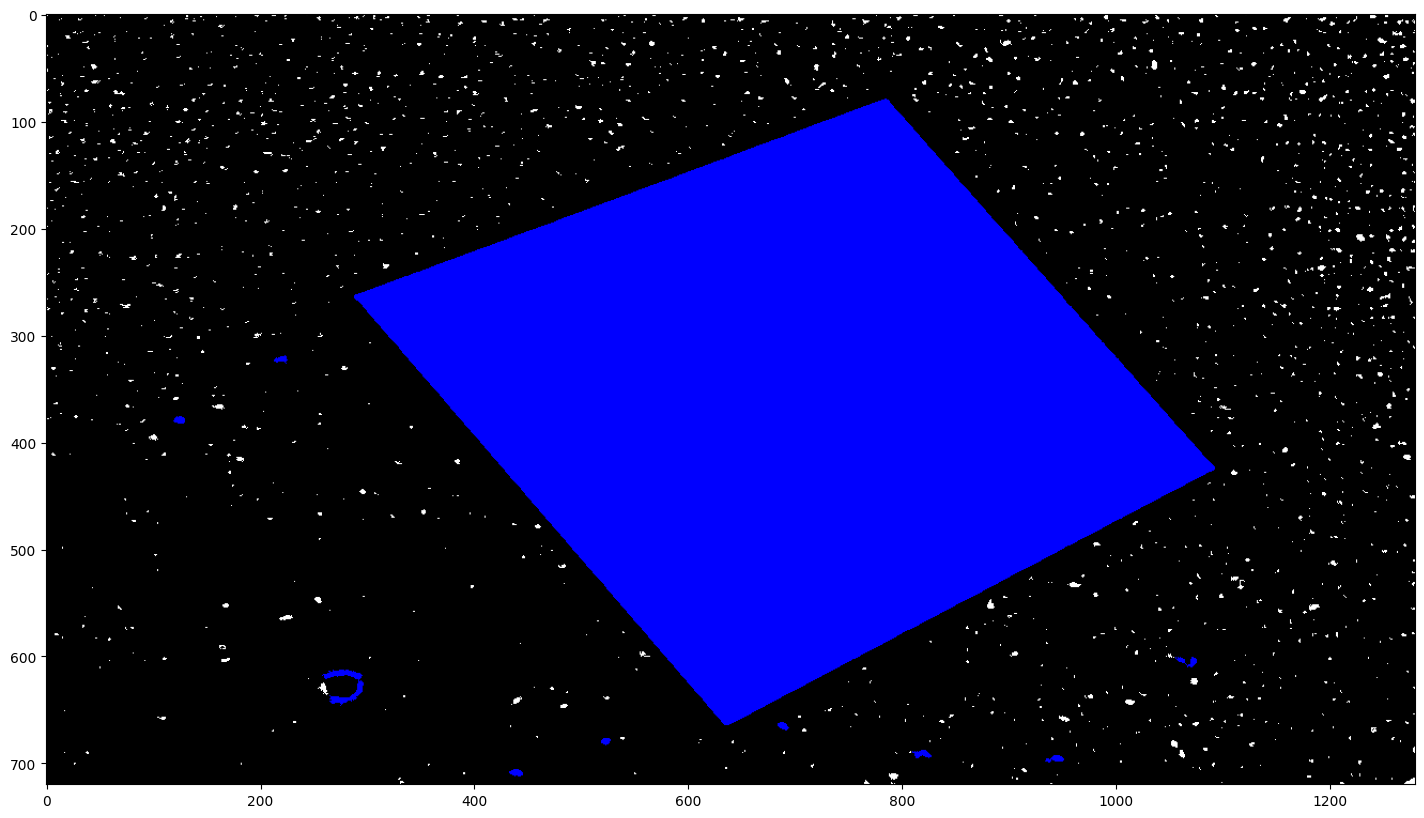

In [147]:
areas = np.array([cv2.contourArea(contour) for contour in contours])
sorted_args = np.argsort(areas)[::-1]
biggest_contours = [contours[index] for index in sorted_args[:10]]
print(f'{areas=}')

display = np.stack([bin_not, bin_not, bin_not], axis=2)
plt.imshow(cv2.drawContours(display, biggest_contours, -1, (0, 0, 255), -1))

While in this case it is obvious that the largest in area item is the puzzle, what might not be always the case. I will add shape in the criteria, so the most **rectangle like** object is also preferred.

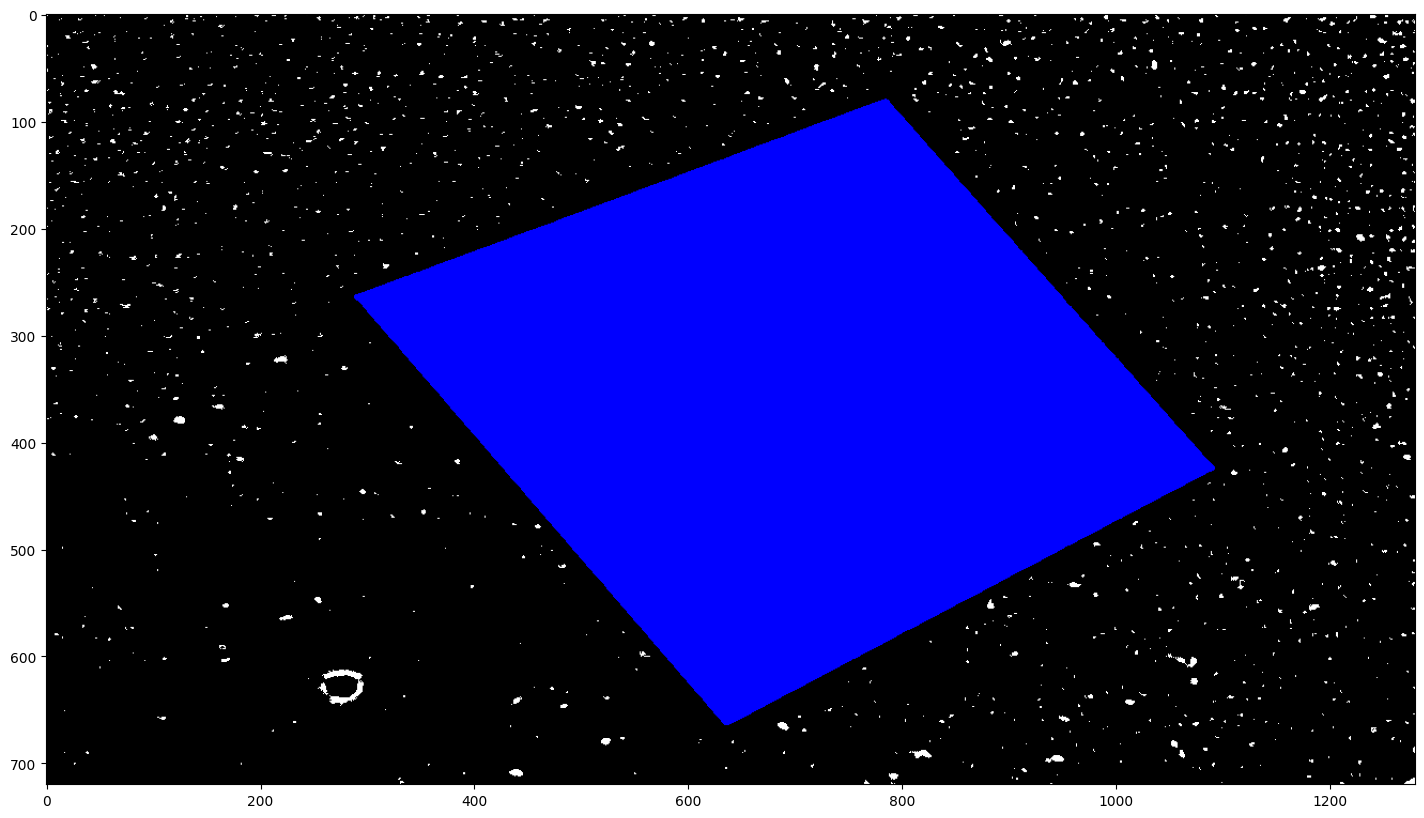

In [148]:
largest_area = 0
largest_contour = None

for contour in contours:
    # Approximate the contour with a polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Check if the approximation has 4 vertices (a rectangle)
    if len(approx) == 4:
        # Calculate the area of the contour
        area = cv2.contourArea(contour)

        # Update the largest contour if this one has a larger area
        if area > largest_area:
            largest_area = area
            largest_contour = contour


display = np.stack([bin_not, bin_not, bin_not], axis=2)
plt.imshow(cv2.drawContours(display, [largest_contour], -1, (0, 0, 255), -1))

It is clear who is the winner. To extract it, I will create a "mask" image. A **mask** is an object that is used to **match patterns** when is **multiplied with other images**. In this case, it is an image with the shape of the puzzle painted with the color=1.

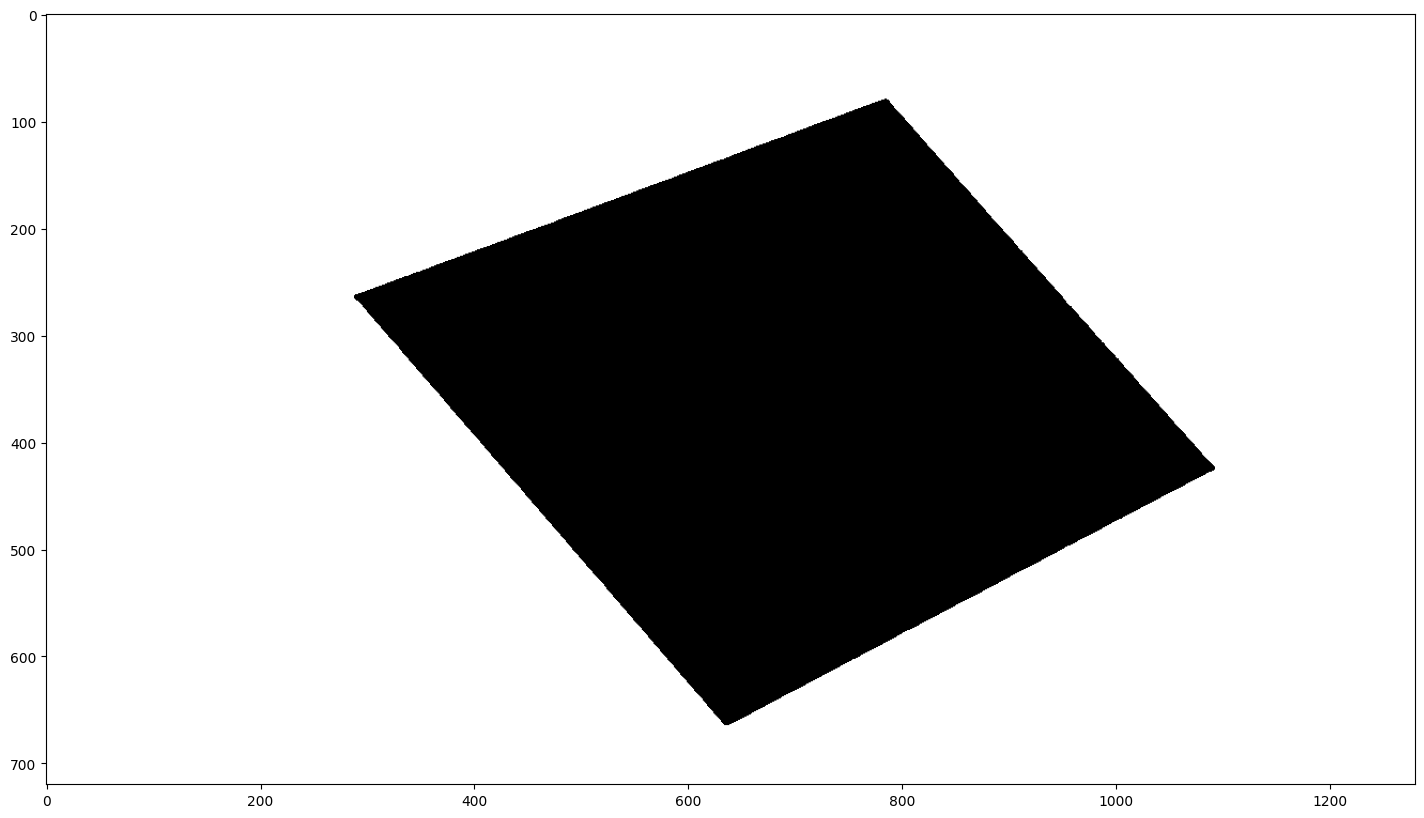

In [149]:
mask = np.zeros(bin_not.shape[:2], dtype="uint8")
cv2.drawContours(mask, [largest_contour], -1, [1], -1)

plt.imshow(mask, cmap='binary')

If we multiply the mask image with the binary image, we will get the sudoku puzzle as it appears, **without noise** around it.

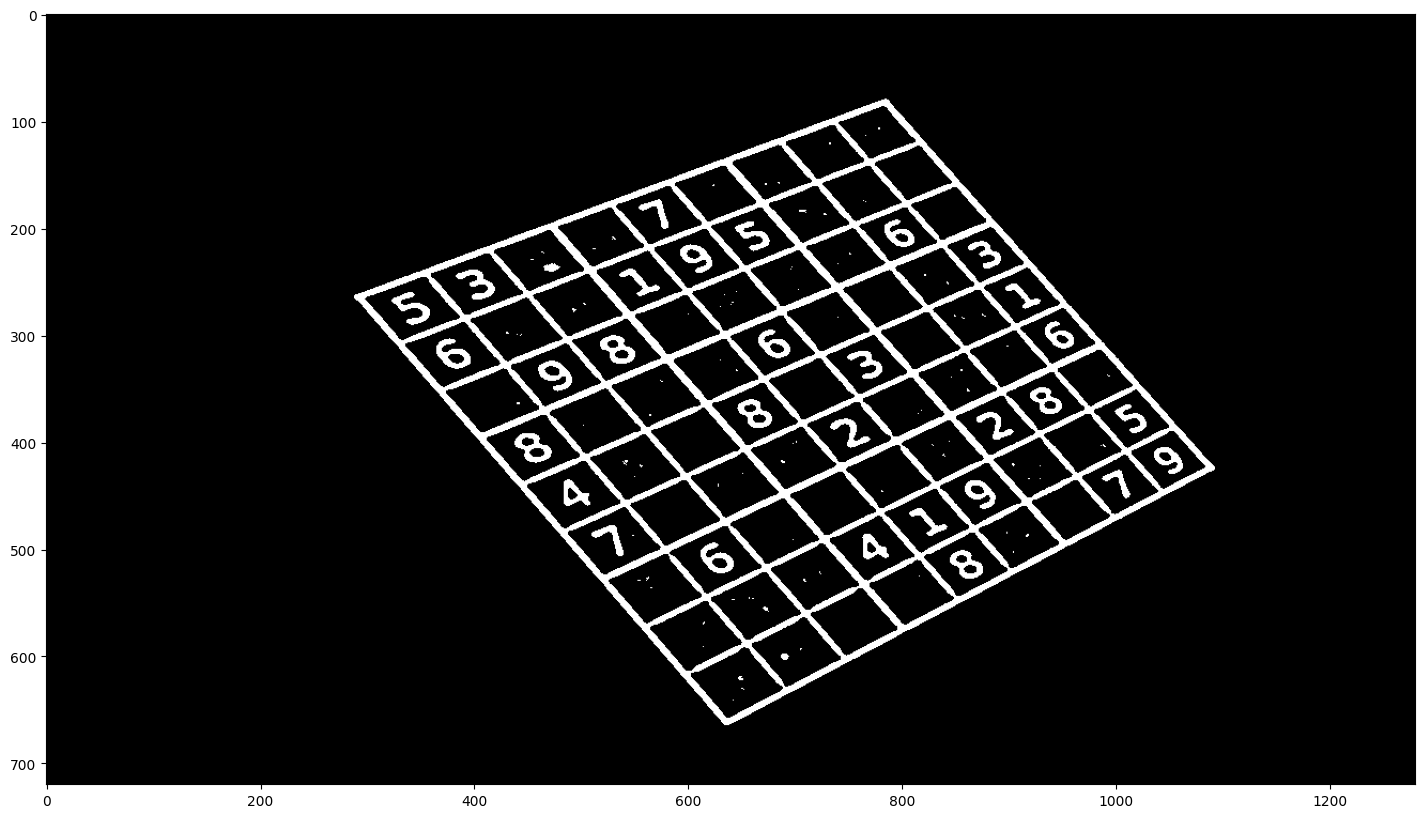

In [150]:
segmented_bin = np.multiply(bin_not, mask)
display = np.stack([segmented_bin]*3, axis=2)
plt.imshow(display)

# Detection
After isolating the sudoku puzzle, we have to understand its orientation in the image.

## Hough Transform
There are many ways to do it, but my personal favorite, and the one I really wanted to use, is the Hough Transform. The transformation takes a binary image, iterates through all of its non-zero points and calculates all the possible lines that can pass through those points. All these lines are describe by their rho and theta value. The rho-theta pairs that have been seen in the most lines, describe the solid long lines.

lines: 12210


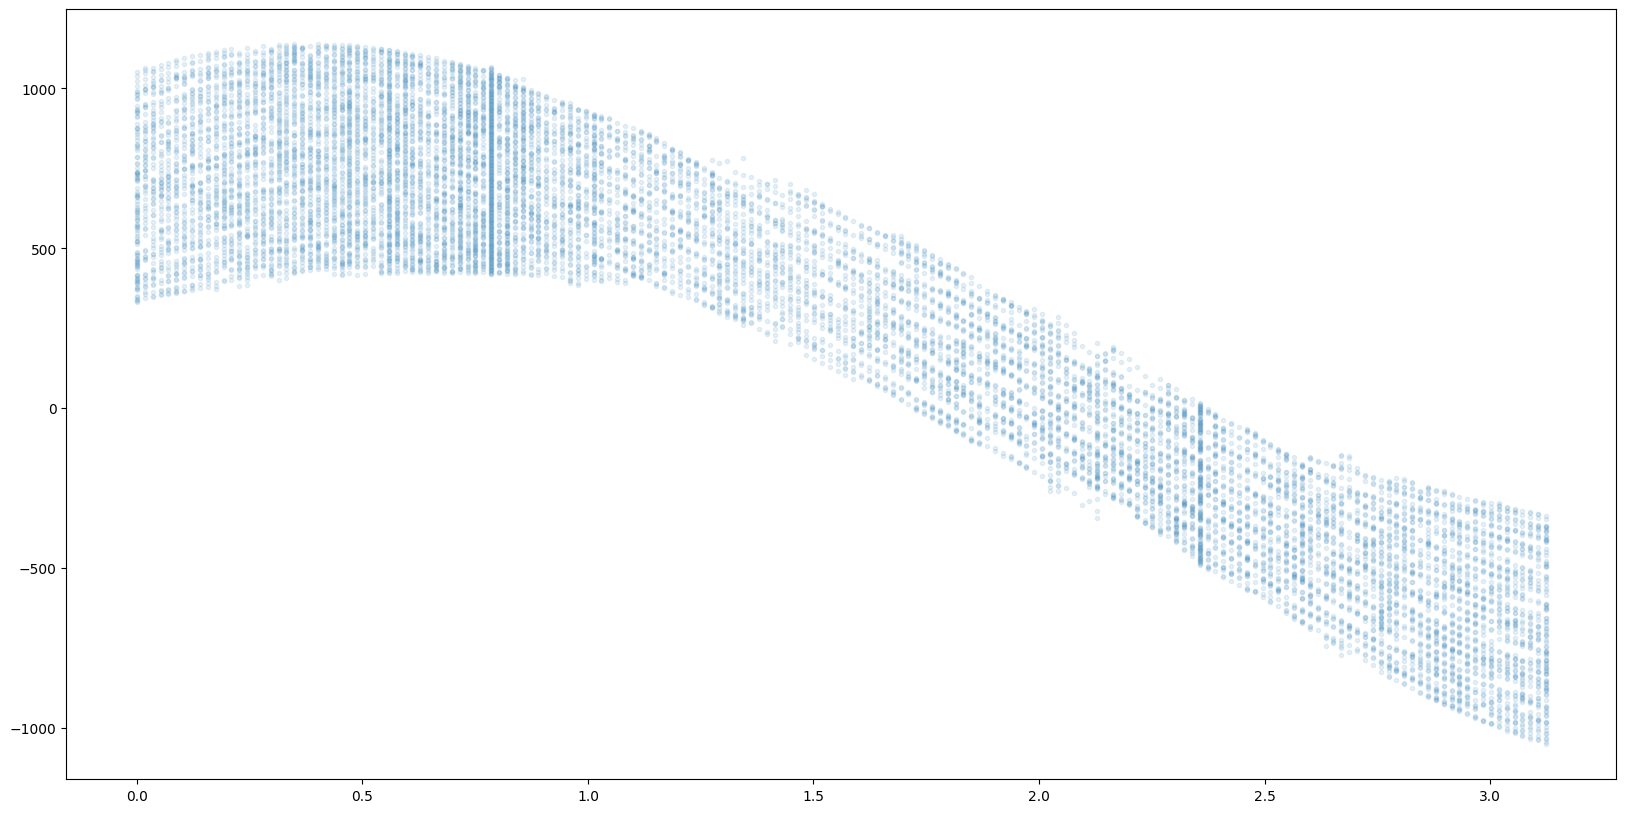

In [168]:
lines = cv2.HoughLines(segmented_bin, 1, np.pi/180, 30)

rhos = np.array([line[0][0] for line in lines])
thetas = np.array([line[0][1] for line in lines])*180/np.pi

plt.scatter(lines[:,0, 1], lines[:,0, 0], alpha=0.1, marker='.')
print('lines:', len(lines))

If we plot all these rho-theta pairs we will see the graph above.

12210


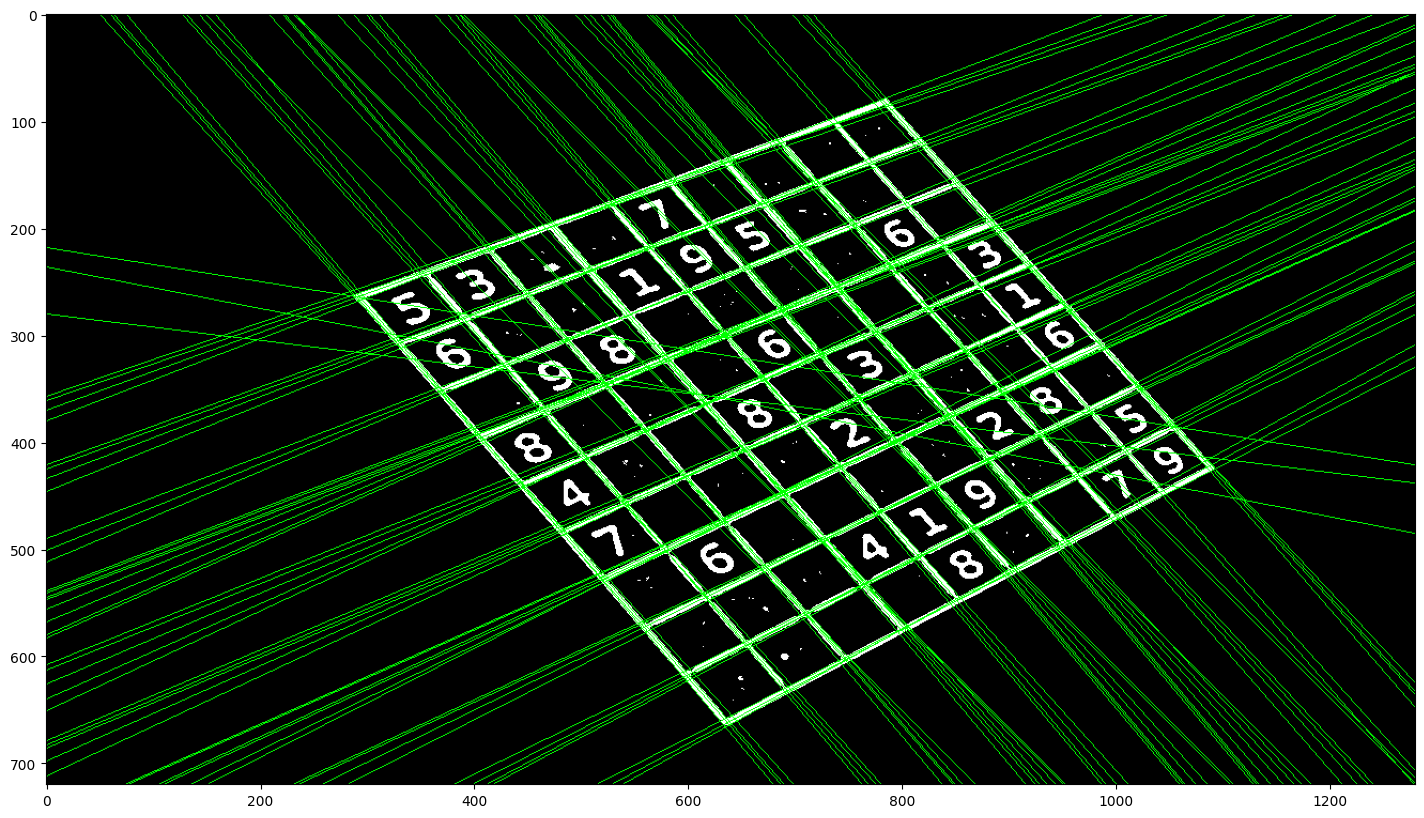

In [178]:
def rho_theta_to_coords(_line):
    _rho, _theta = _line
    a = np.cos(_theta)
    b = np.sin(_theta)
    x0 = a*_rho
    y0 = b*_rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))

    return x1, y1, x2, y2

lines = cv2.HoughLines(segmented_bin, 1, np.pi/180, 30)
print(len(lines))

display = np.stack([segmented_bin]*3, axis=2)
for line in lines[:100]:
    x1, y1, x2, y2 = rho_theta_to_coords(line[0])
    cv2.line(display,(x1,y1),(x2,y2),(0,255,0),1)
plt.imshow(display)

We can see that even a small subset of the returned lines can help as **extract information** about orientation, field of view, depth, etc.

In this example I will extract the points of the **4 corners of the puzzle**. This 4 points will then be **used to transform the image** to a more useful perspective.

More specifically, I will choose the **2 large sets of perpendicular lines**, and from their **intersection points** i ll pick the **outer 4**.

th_range_factor = [0.93333326 0.73333325]
verticality_factor = 0.8091250032111836
count_factor = [0.54761905 0.45238095]
final_points [[ 288.  265.]
 [ 643.  659.]
 [1086.  424.]
 [ 789.   83.]]


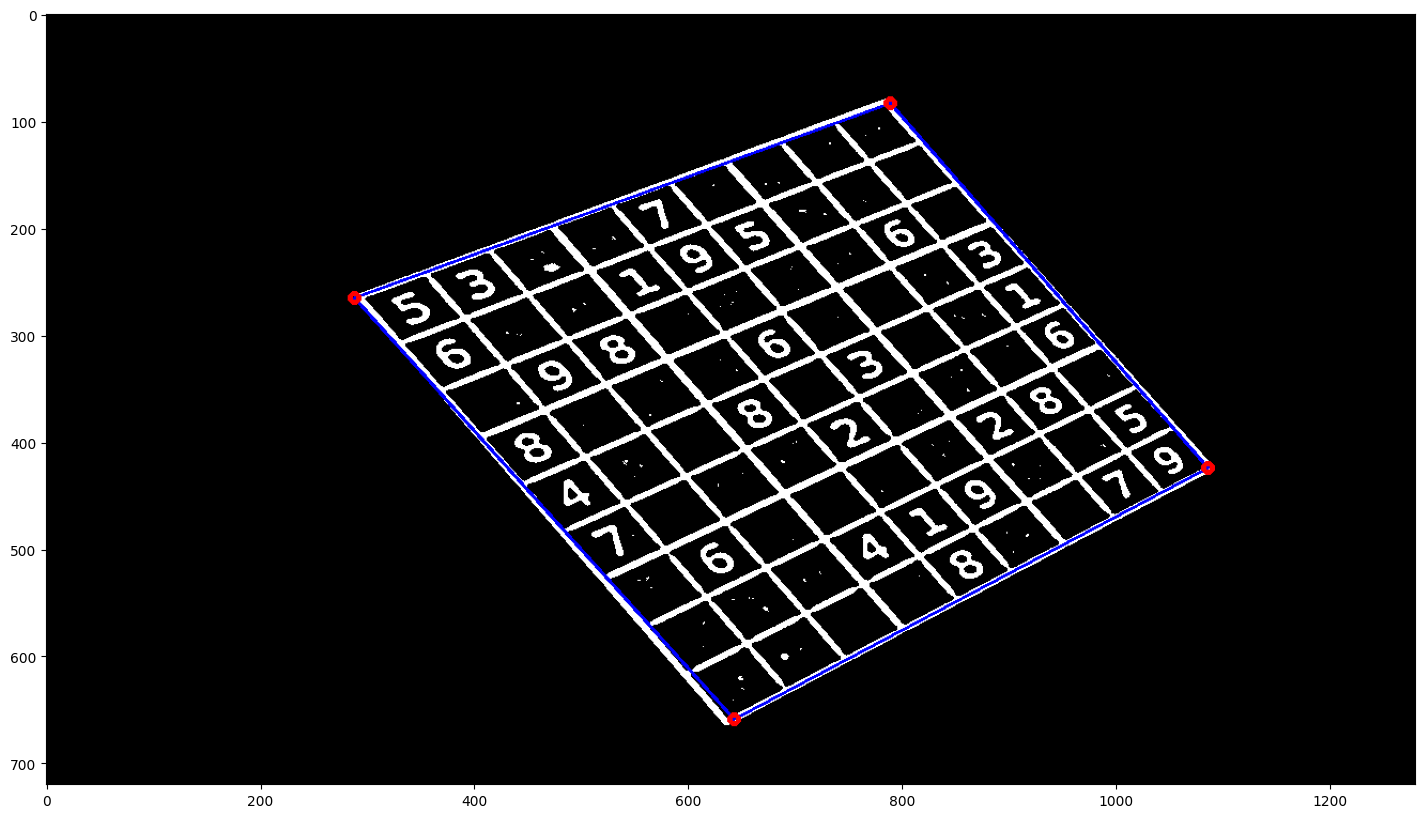

In [197]:
def cytrav(arr, index, window):
    return np.array([arr[i] for i in np.mod(index+np.arange(window)-int(window/2), len(arr))])

def rho_theta_to_coords(line, image_shape=None):
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))

    return [x1, y1, x2, y2]

def line_intersect(A1, A2, B1, B2):
    # https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines-in-python
    def slope(P1, P2):
        if P2[1] - P1[1] == 0:
            if P2[0]-P1[0] >= 0:
                return np.finfo(np.float).max
            else:
                return np.finfo(np.float).min
        return(P2[0] - P1[0]) / (P2[1] - P1[1])

    def y_intercept(P1, slope):
        return P1[0] - slope * P1[1]

    m1, m2 = slope(A1, A2), slope(B1, B2)
    if m1 == m2:
        return None

    b1, b2, = y_intercept(A1, m1), y_intercept(B1, m2)

    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return [y, x]

def order_points(pts):
    # https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
    rect = np.zeros((4, 2), dtype="float32")
    s = np.sum(pts, axis=1)
    diff = np.diff(pts, axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[1] = pts[np.argmax(diff)]
    rect[2] = pts[np.argmax(s)]
    rect[3] = pts[np.argmin(diff)]
    return rect

lines = cv2.HoughLines(segmented_bin, 1, np.pi/180, 30)

lines = lines[:min(50, len(lines))]

rhos = np.array([line[0][0] for line in lines])
thetas = np.array([line[0][1] for line in lines])*180/np.pi

th_range = 30
thetas = np.sort(thetas)

thetas = np.hstack([thetas[np.searchsorted(thetas, 180-th_range, side='right'):]-180, thetas])
th_count = np.array([np.subtract(t[1], t[0]) for t in [np.searchsorted(thetas, [th-th_range, th],
                                                                       side='right') for th in range(180)]])
f_th = np.copy(th_count)
for i, th in enumerate(th_count):
    frame = cytrav(th_count, i, 50)
    if any(th < frame):
        f_th[i] = 0

res = []
s = -1
for i in range(len(f_th)):
    if f_th[i] > f_th[i-1] and s < 0:
        s = i
    if f_th[i] < f_th[i-1] and s >= 0:
        ind = np.average([s, i]).astype(np.int64)
        res.append(ind)
        s = -1
res = np.array(res)
# if len(res) < 2:
#     ev = 0
# else:
res = res[np.argsort(th_count[res])[::-1]]
res = res[:2]*np.pi/180

ls = [np.array([l[0] for l in lines if abs(l[0][1]-th) < np.pi/6]) for th in res]
# for l in ls[0]:
#     y1, x1, y2, x2 = rho_theta_to_coords(l)
#     cv2.line(display, (x1, y1), (x2, y2), (0, 0, 255), 1)
# for l in ls[1]:
#     y1, x1, y2, x2 = rho_theta_to_coords(l)
#     cv2.line(display, (x1, y1), (x2, y2), (0, 255, 0), 1)
line_stats = np.transpose([[np.min(ths),
                            np.max(ths),
                            np.average(ths),
                            len(ths)]
                           for ths in [[line[1] for line in l] for l in ls] if len(ths) > 0])

# print(line_stats)
min_th, max_th, avg_th, count = line_stats
# print(min_th, max_th, avg_th, count)
th_range_factor = np.abs(np.pi/6-np.abs(max_th-min_th))/(np.pi/6)
print("th_range_factor = {}".format(th_range_factor))

verticality_factor = 1-np.abs(np.abs(avg_th[0]-avg_th[1])/(np.pi/2)-1)
print("verticality_factor = {}".format(verticality_factor))

count_threshold = 4
count_factor = (count-count_threshold)/(len(lines)-2*count_threshold)
print("count_factor = {}".format(count_factor))

ev = np.sum(np.multiply(th_range_factor, count_factor))*verticality_factor

# cv2.putText(display, "{}%".format(ev*100),
#             (10, display.shape[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, int(ev*255), int((1-ev)*255)))
# cv2.drawContours(display, [contour], -1, (0, int(ev*255), int((1-ev)*255)), 2)

value_threshold = .75
l_inds = np.array([[np.argmin(rhos), np.argmax(rhos)]
                   for rhos in [[line[0] for line in l] for l in ls]])
l1_min, l1_max = [rho_theta_to_coords(l) for l in ls[0][l_inds[0]]]
l2_min, l2_max = [rho_theta_to_coords(l) for l in ls[1][l_inds[1]]]

final_points = np.around([line_intersect(l1_min[: 2], l1_min[2:], l2_min[: 2], l2_min[2:]),
                          line_intersect(l1_min[: 2], l1_min[2:], l2_max[: 2], l2_max[2:]),
                          line_intersect(l1_max[: 2], l1_max[2:], l2_min[: 2], l2_min[2:]),
                          line_intersect(l1_max[: 2], l1_max[2:], l2_max[: 2], l2_max[2:])]).astype(np.int64)

final_points = order_points(final_points)
print('final_points', final_points)
display = np.stack([segmented_bin]*3, axis=2)
cv2.polylines(display, np.int32([final_points]), True, (0, 0, 255), 2)
[cv2.circle(display, (int(point[0]), int(point[1])), 4, (255, 0, 0), 4) for point in final_points]
plt.imshow(display)

Now we have these 4 points roughly on the corners of the puzzle. This will help us **transform the image to a rectangular** one, with less noise and more predicted locations for the sudoku puzzle digits.

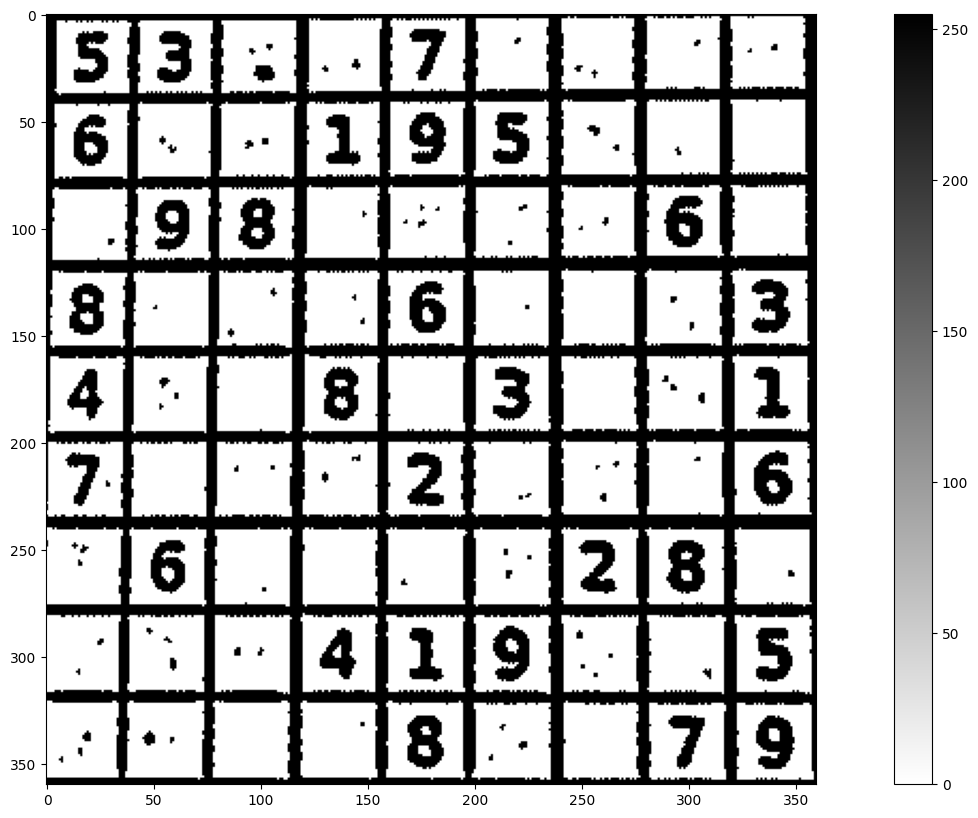

In [203]:
DIGIT_RESOLUTION = np.array([40, 40])

dest_shape = segmented_bin.shape
#
# if src_pts is None:
#     src_pts = [[y, x] for y in [0, src.shape[0]] for x in [0, src.shape[1]]]

dest_pts = [[x, y] for y in [0, segmented_bin.shape[0]] for x in [0, segmented_bin.shape[1]]]

src_pts = np.float32(order_points(final_points))
dest_pts = np.float32(order_points(dest_pts))

# src_pts = np.flip(src_pts, 1)
# dest_pts = np.flip(dest_pts, 1)

M = cv2.getPerspectiveTransform(src_pts, dest_pts)
projected_image = cv2.warpPerspective(segmented_bin, M, dest_shape[::-1])

sudoku_image = cv2.resize(projected_image, (9*DIGIT_RESOLUTION[0], 9*DIGIT_RESOLUTION[1]))
sudoku_bin = np.where(sudoku_image>0, 255, 0)

plt.imshow(sudoku_bin, cmap='binary')
plt.colorbar()

# Fetch the sudoku puzzle digits

Here I will try to fetch the digits of the puzzle, in order to reconstruct it in a tabular form that can be easily recognised by a sudoku solver.

## Predict the digits' locations

As you can see on the image above, the sudoku 9x9 grid not perfectly aligned. The left line disappears as it goes down. Also in some cases, the lines surrounding each 3x3 might be significantly thicker depending on the style. These two effects don't allow us to assume that the digits are located in specific positions.

To account for this inaccuracy, I will need to search around the estimated locations. The estimated center locations are obviously in the middle of each of the 9 columns and 9 rows.

One way of doing this is to find all the contours and pick the ones that surround the center points. This sometimes fails because the digits may contain holes or be shifted slightly to the side which will through the center point out of the bounding box.
To grab the digits I will use a technique aspired from the Claw machines. I will draw a claw-like shape in the center of each estimated position.


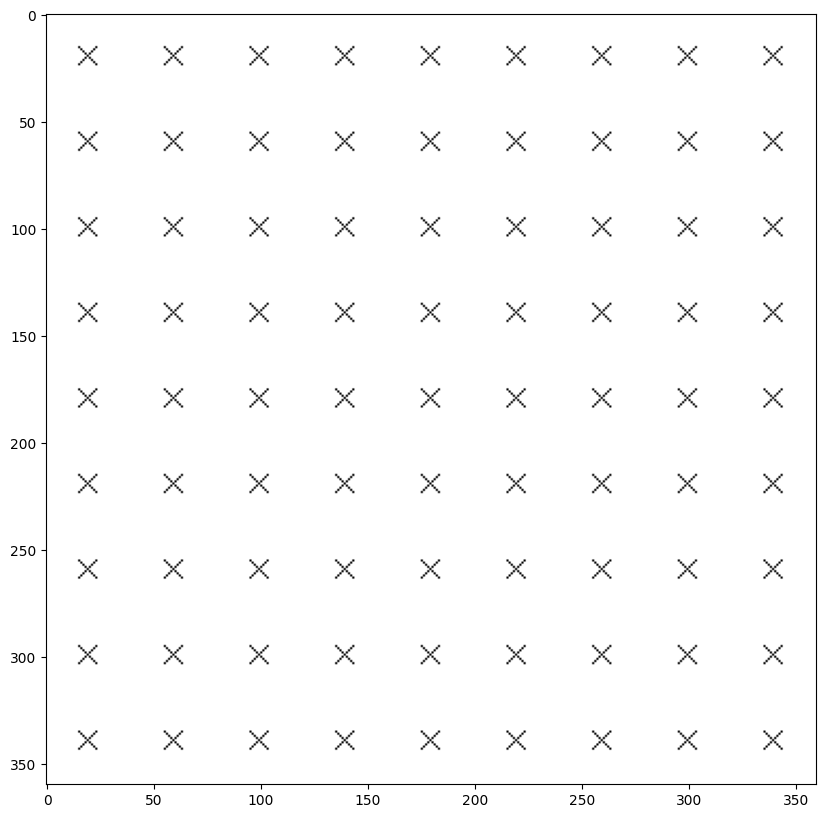

In [207]:
img_shape = sudoku_bin.shape
mid_points = (DIGIT_RESOLUTION/2+np.array([np.array([x, y]) for x in np.arange(9)
                                                 for y in np.arange(9)])*(DIGIT_RESOLUTION)).astype(np.int64)
claw_size = 9

claw = np.array(
        [[255 if i == j or i == claw_size-1-j else 0 for i in range(claw_size)] for j in range(claw_size)]).astype(np.int64)

claw_mask = np.zeros(img_shape, dtype=np.int64)
for p in mid_points:
    claw_mask[int(p[0]-claw_size/2):int(p[0]+claw_size / 2),
         int(p[1]-claw_size/2):int(p[1]+claw_size / 2)] += claw


plt.imshow(claw_mask, cmap='binary')


I will then overlay the claws and the sudoku image. This way I will ensure that there the claws are touching the digit, and therefore we have a solid structure containing them.

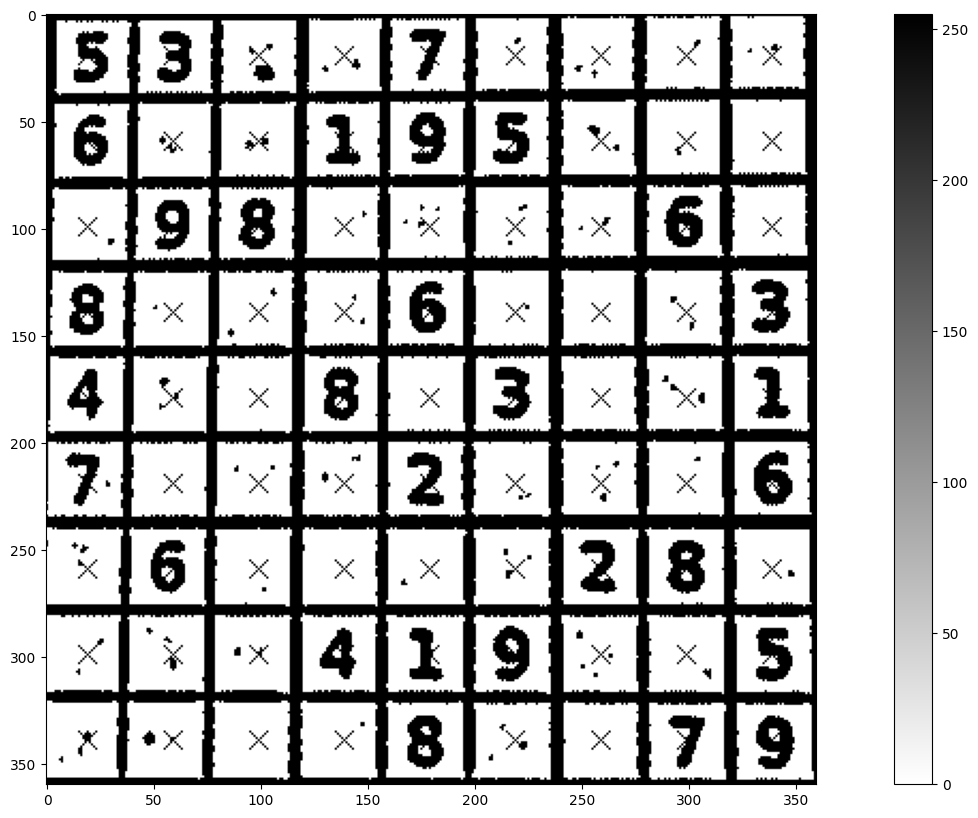

In [208]:
img = sudoku_bin
mid_points = (2*DIGIT_RESOLUTION/5+np.array([np.array([x, y]) for x in np.arange(9)
                                             for y in np.arange(9)])*(DIGIT_RESOLUTION)).astype(np.int64)

# claws = claw_mask(img.shape, mid_points, 9)*255
claws = claw_mask

claws_on_sudoku = cv2.bitwise_or(img, claws)

plt.imshow(claws_on_sudoku, cmap='binary')
plt.colorbar()

We can clearly see that all the claws have grabbed the digits.

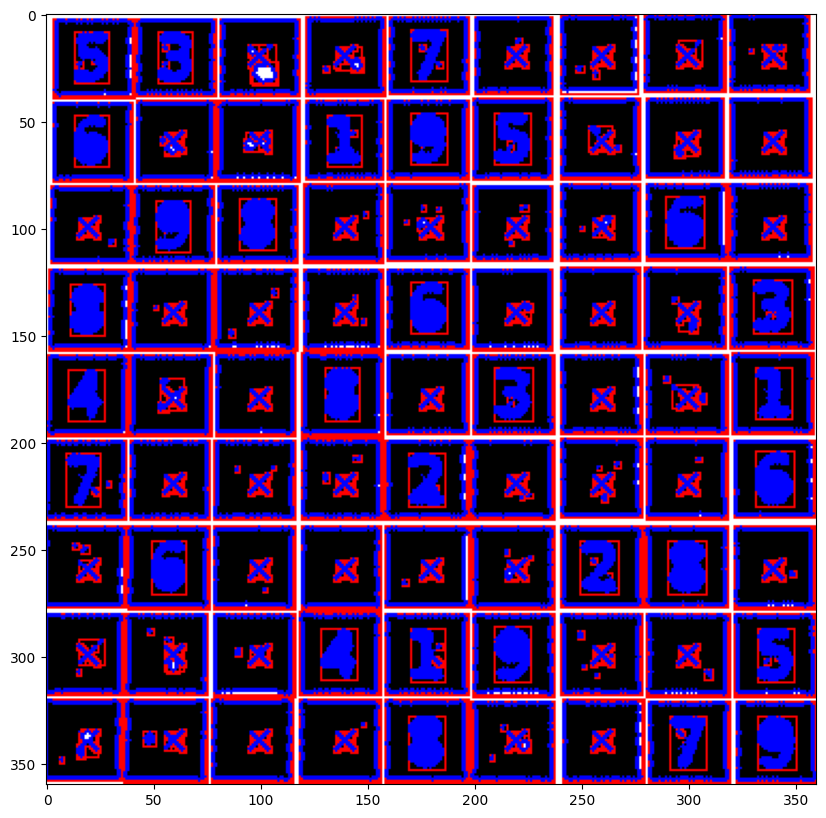

In [230]:
all_contours, hierarchys = cv2.findContours(255-claws_on_sudoku, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)


# plt.imshow(cv2.drawContours(display, all_contours, -1, (0, 0, 255), -1))
# plt.imshow(claws_on_sudoku)
# print(display.shape, len(all_contours))

outer_boxes = [cv2.boundingRect(cnt) for cnt, hierarchy in zip(all_contours, hierarchys[0]) if (hierarchy[3] == -1 and hierarchy[0] >= 0)]
outer_contours = [cnt for cnt, hierarchy in zip(all_contours, hierarchys[0]) if (hierarchy[3] == -1)]
# grabbed_contours = [cnt for cnt in outer_contours if any([(cv2.pointPolygonTest(cnt, np.float32(p), False) > -1) for p in mid_points])]
grabbed_contours = [cnt for cnt in outer_contours if any([(cv2.pointPolygonTest(cnt, np.float32(p), False) > -1) for p in mid_points])]

display = np.stack([claws_on_sudoku, claws_on_sudoku, claws_on_sudoku], axis=2)
[cv2.rectangle(display, (x,y), (x+w,y+h), (255, 0, 0), 1) for x,y,w,h in outer_boxes]


areas = [np.prod(cv2.boundingRect(cnt)[2:]) for cnt in grabbed_contours]

certain_size_contours = [cnt for i, cnt in enumerate(grabbed_contours) if areas[i] < 1000 and areas[i]>200]

# display = np.stack([claws_on_sudoku, claws_on_sudoku, claws_on_sudoku], axis=2)
cv2.drawContours(display, outer_contours, -1, (0, 0, 255), -1)
plt.imshow(display)

To fetch the grabbed digit we will use the mask technique again.

(360, 360) 31


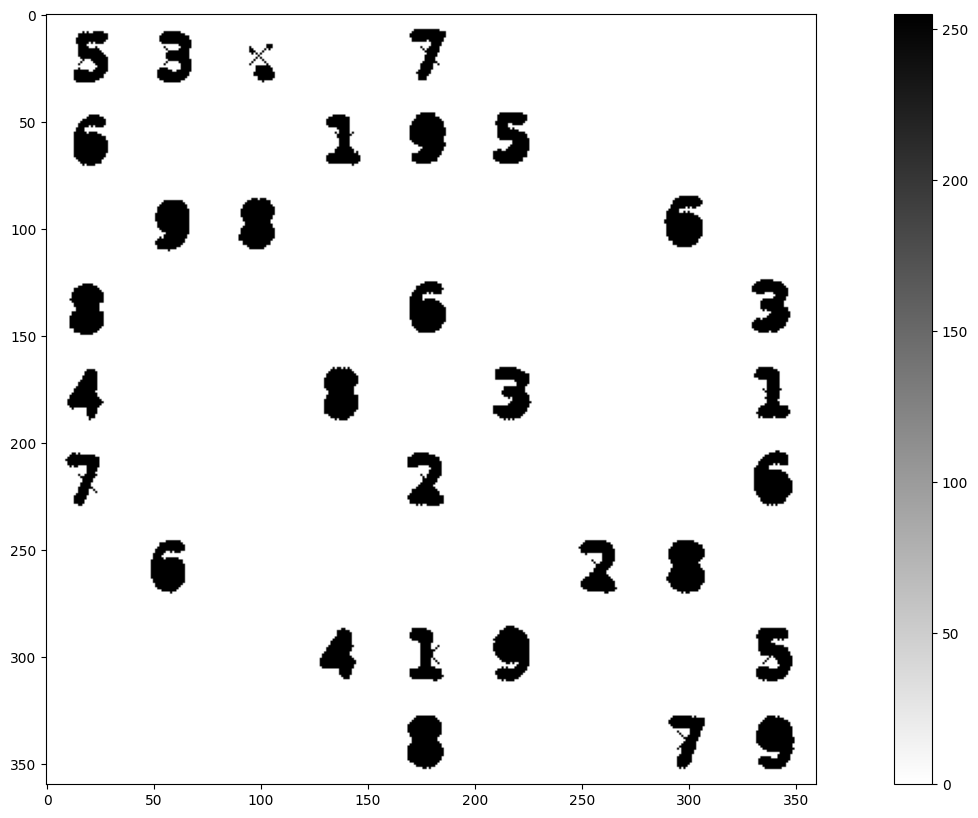

In [231]:
digits_mask = np.zeros(sudoku_bin.shape, np.uint8)
print(digits_mask.shape, len(certain_size_contours))
cv2.drawContours(digits_mask, certain_size_contours, -1, [255], -1)

# # # box_mask = np.zeros(img.shape, np.uint8)
# boxes = np.array([cv2.boundingRect(cnt) for cnt in certain_size_contours])
#
# grabbed_items = [img[y:y+h, x:x+w] for x, y, w, h in boxes]

plt.imshow(digits_mask, cmap='binary')
plt.colorbar()

If we bitwise_or the mask and the sudoku binary image, the claws will be removed.



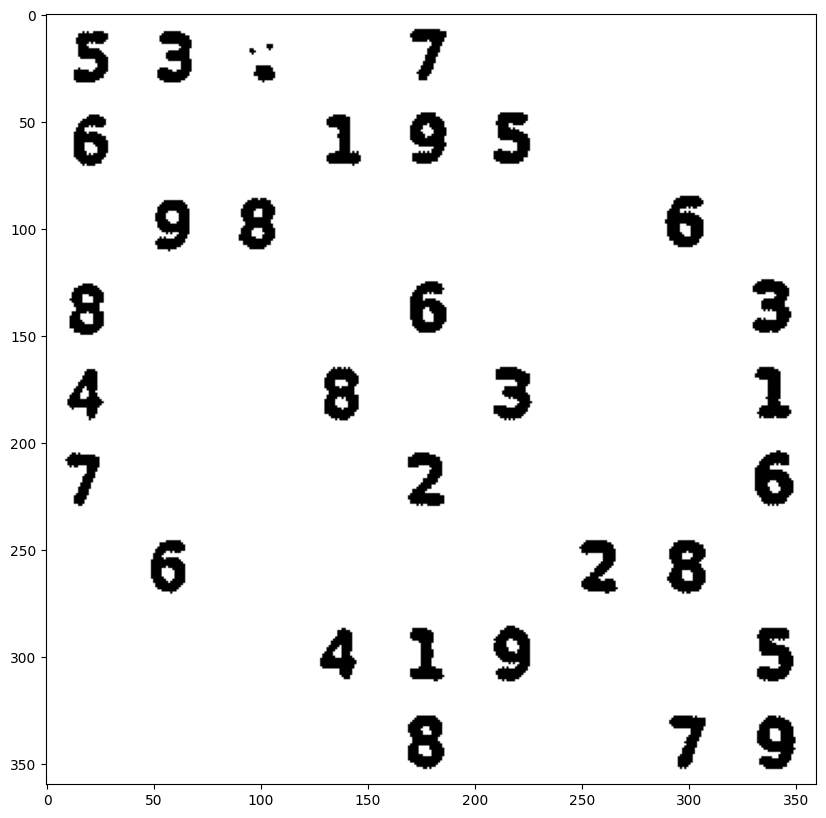

In [232]:
digits_only = cv2.bitwise_and(sudoku_bin.astype(np.uint8), digits_mask)

plt.imshow(digits_only, cmap='binary')

The caveat is that some noise particles are grabbed too.

To get rid of them too, we can filter the results by surface area. Digits are larger.

30


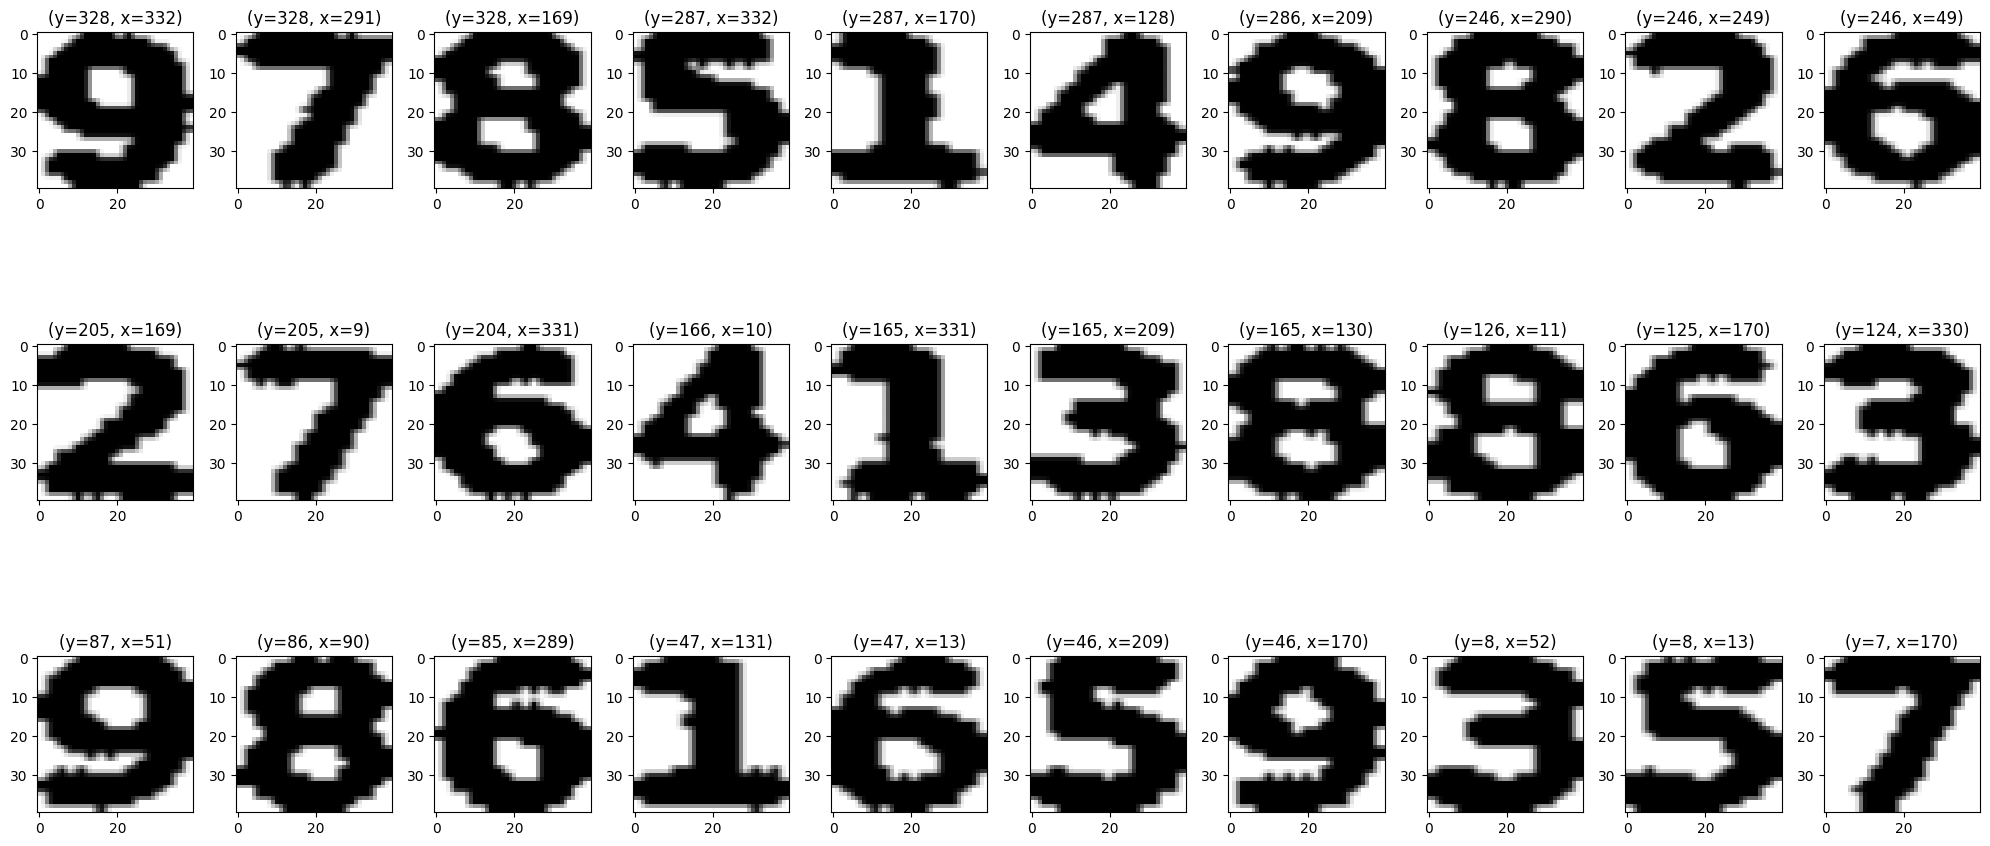

In [241]:
digit_contours, hierarchys = cv2.findContours(digits_only, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

filtered_contours = [cnt for cnt in digit_contours if np.prod(cv2.boundingRect(cnt)[2:]) < 1000 and np.prod(cv2.boundingRect(cnt)[2:])>200]
print(len(filtered_contours))
digit_contours_box = [cv2.boundingRect(cnt) for cnt in filtered_contours]
digit_contours_rect = [[x, y, x+w, h+y] for x, y, w, h in digit_contours_box]


digits = []
boxes = []

for cnt in filtered_contours:
    x, y, w, h = cv2.boundingRect(cnt)
    digit = cv2.resize(digits_only[y:y+h, x:x+w], DIGIT_RESOLUTION)

    digits.append(digit)
    boxes.append([y, x, h, w])

digits = np.array(digits)
boxes = np.array(boxes)


for i, digit in enumerate(digits):
    plt.subplot(3, len(digits)//3, i+1)
    y, x, h, w = boxes[i]
    plt.title(f"({y=}, {x=})")
    plt.imshow(digit, cmap='binary')
plt.tight_layout()

## Reconstruction of the sudoku table.

All the digits are now fetched correctly. We also have their positions from which we can find their locations on the table, and also predict hte locations and sizes of the missing digits.

In [242]:
digit_boxes = boxes

def calculate(i, x, y):
    if i in x:
        return y[x.index(i)]
    l = np.searchsorted(x, i)-1
    r = l+1
    x1, y1 = (x[l], y[l]) if l >= 0 else (x[0]-1, y[0])
    x2, y2 = (x[r], y[r]) if r < len(x) else (x[len(x)-1]+1, y[len(x)-1])
    yi = (y2-y1)/(x2-x1)*(i-x1)+y1

    return yi

mid_locations = np.array([[int(y+h/2), (x+w/2)] for y, x, h, w in boxes])
table_locations = np.array(mid_locations/DIGIT_RESOLUTION).astype(np.int64)

sorted_ys = [boxes[np.where(table_locations[:, 0] == n)[0], 0] for n in range(9)]

avg_ys, inds = np.transpose(np.around([(np.average(y), i)
                                       for i, y in enumerate(sorted_ys) if len(y) > 0]).astype(np.int64))
ys = np.array([calculate(yi, list(inds), list(avg_ys)) for yi in range(9)], np.int64)

sorted_xs = [boxes[np.where(table_locations[:, 0] == n)[0], 0] for n in range(9)]
avg_xs, inds = np.transpose(np.around([(np.average(x), i)
                                       for i, x in enumerate(sorted_xs) if len(x) > 0]).astype(np.int64))
xs = np.array([calculate(xi, list(inds), list(avg_xs)) for xi in range(9)], np.int64)

yx_points = [[(y, x) for x in xs] for y in ys]

dims = np.array([[h, w] for y, x, h, w in boxes])

avg_dims = np.around(np.average(dims, axis=0)).astype(np.int64)

print(yx_points, avg_dims)
print(table_locations)
# return table_locations, yx_points, avg_dims

[[(8, 8), (8, 46), (8, 86), (8, 125), (8, 165), (8, 205), (8, 246), (8, 287), (8, 328)], [(46, 8), (46, 46), (46, 86), (46, 125), (46, 165), (46, 205), (46, 246), (46, 287), (46, 328)], [(86, 8), (86, 46), (86, 86), (86, 125), (86, 165), (86, 205), (86, 246), (86, 287), (86, 328)], [(125, 8), (125, 46), (125, 86), (125, 125), (125, 165), (125, 205), (125, 246), (125, 287), (125, 328)], [(165, 8), (165, 46), (165, 86), (165, 125), (165, 165), (165, 205), (165, 246), (165, 287), (165, 328)], [(205, 8), (205, 46), (205, 86), (205, 125), (205, 165), (205, 205), (205, 246), (205, 287), (205, 328)], [(246, 8), (246, 46), (246, 86), (246, 125), (246, 165), (246, 205), (246, 246), (246, 287), (246, 328)], [(287, 8), (287, 46), (287, 86), (287, 125), (287, 165), (287, 205), (287, 246), (287, 287), (287, 328)], [(328, 8), (328, 46), (328, 86), (328, 125), (328, 165), (328, 205), (328, 246), (328, 287), (328, 328)]] [25 17]
[[8 8]
 [8 7]
 [8 4]
 [7 8]
 [7 4]
 [7 3]
 [7 5]
 [6 7]
 [6 6]
 [6 1]
 [5

# Understand the meaning of the images.

To understand and **recognise each digit image** in order to **map it to the correct number**, we have to either match it to a known image pattern for each digit, or to use an ML classifier. Both of these solutions are difficult to implement, train, and make sure that they will work for any font and size.

Another idea came to my mind, and I really wanted to try it. We know that all numbers will be writen with the same font and size. We also know that the actual number is not useful for the sudoku puzzle to be solver, it is just a symbol. Each number is a different symbol representing another group. To us, it doesn't matter if each row, column or 3x3 square has one nine, one 8 and so on. We only care that they contain 9 unique symbols, consistent to the grid. For example, we can swap any 6s with the 9s, or 3s with 2s, or 4s with potatoes, and the solution will still be consistent and "identical", or in other words it will have the same form.

So I decided group the digit images, instead of classify them. Then I can assign one label, or number to each group and solve the sudoku puzzle containing the labels and not the actual meaning of the images. As long as the groups are consistent and are labeled differently from the other groups, it should be fine.

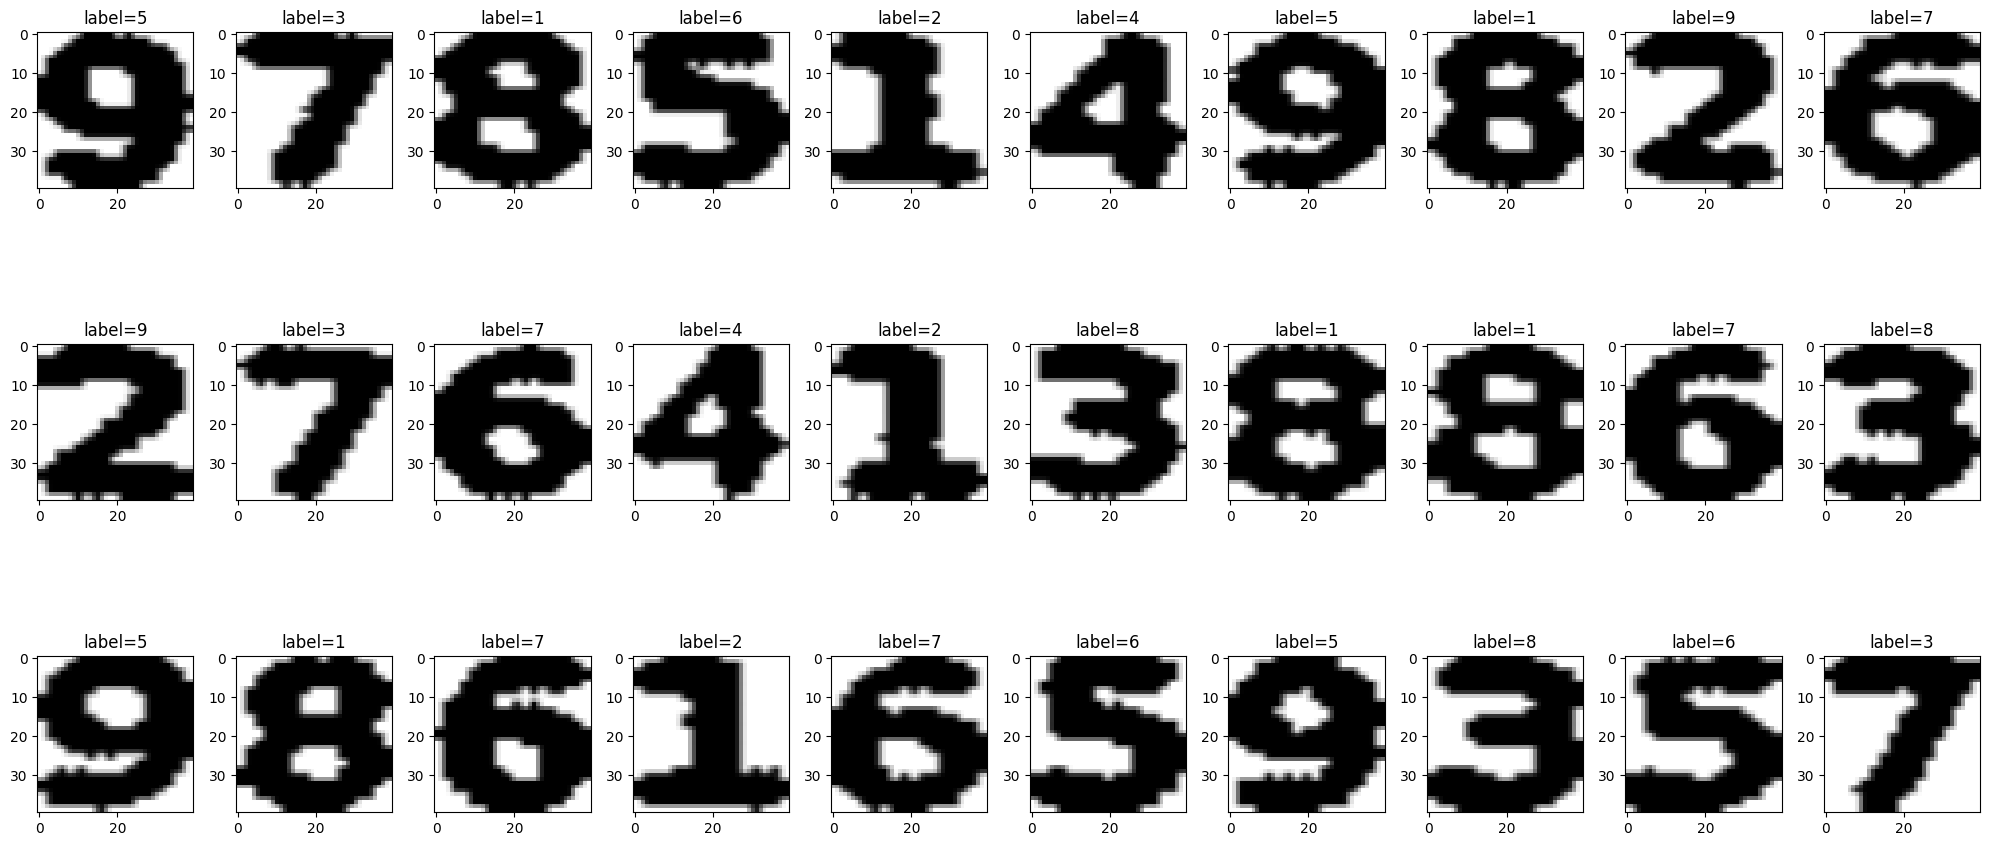

In [243]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto").fit([digit.flatten() for digit in digits])
labels = [l+1 for l in kmeans.labels_]
i = 0
for label, digit in zip(labels, digits):
    plt.subplot(3, len(digits)//3, i+1)
    plt.title(f"{label=}")
    plt.imshow(digit, cmap='binary')
    i+=1
plt.tight_layout()


Now let's reconstruct the sudoku puzzle table with the labels

In [28]:
unsolved_sudoku_table = np.zeros((9, 9), np.int64)
for digit, (y, x), label in zip(digits, table_locations, labels):
    unsolved_sudoku_table[y][x] = label
print(unsolved_sudoku_table)

[[6 8 0 0 3 0 0 0 0]
 [7 0 0 2 5 6 0 0 0]
 [0 5 1 0 0 0 0 7 0]
 [1 0 0 0 7 0 0 0 8]
 [4 0 0 1 0 8 0 0 2]
 [3 0 0 0 9 0 0 0 7]
 [0 7 0 0 0 0 9 1 0]
 [0 0 0 4 2 5 0 0 6]
 [0 0 0 0 1 0 0 3 5]]


We initialise a Sudoku object that will help use solve the puzzle.

In [245]:
from sudoku import Sudoku
sudoku = Sudoku(3, 3, board=unsolved_sudoku_table)
sudoku.show()

+-------+-------+-------+
| 6 8   |   3   |       |
| 7     | 2 5 6 |       |
|   5 1 |       |   7   |
+-------+-------+-------+
| 1     |   7   |     8 |
| 4     | 1   8 |     2 |
| 3     |   9   |     7 |
+-------+-------+-------+
|   7   |       | 9 1   |
|       | 4 2 5 |     6 |
|       |   1   |   3 5 |
+-------+-------+-------+



And then let's solve it.

In [248]:
solution = sudoku.solve()
solution.show()
solved_sudoku_table = solution.board

+-------+-------+-------+
| 6 8 4 | 7 3 1 | 5 2 9 |
| 7 3 9 | 2 5 6 | 8 4 1 |
| 2 5 1 | 8 4 9 | 6 7 3 |
+-------+-------+-------+
| 1 6 5 | 3 7 2 | 4 9 8 |
| 4 9 7 | 1 6 8 | 3 5 2 |
| 3 2 8 | 5 9 4 | 1 6 7 |
+-------+-------+-------+
| 5 7 2 | 6 8 3 | 9 1 4 |
| 9 1 3 | 4 2 5 | 7 8 6 |
| 8 4 6 | 9 1 7 | 2 3 5 |
+-------+-------+-------+



If now we reverse map the label to the digit images, the sudoku image will represent the solved sudoku puzzle.

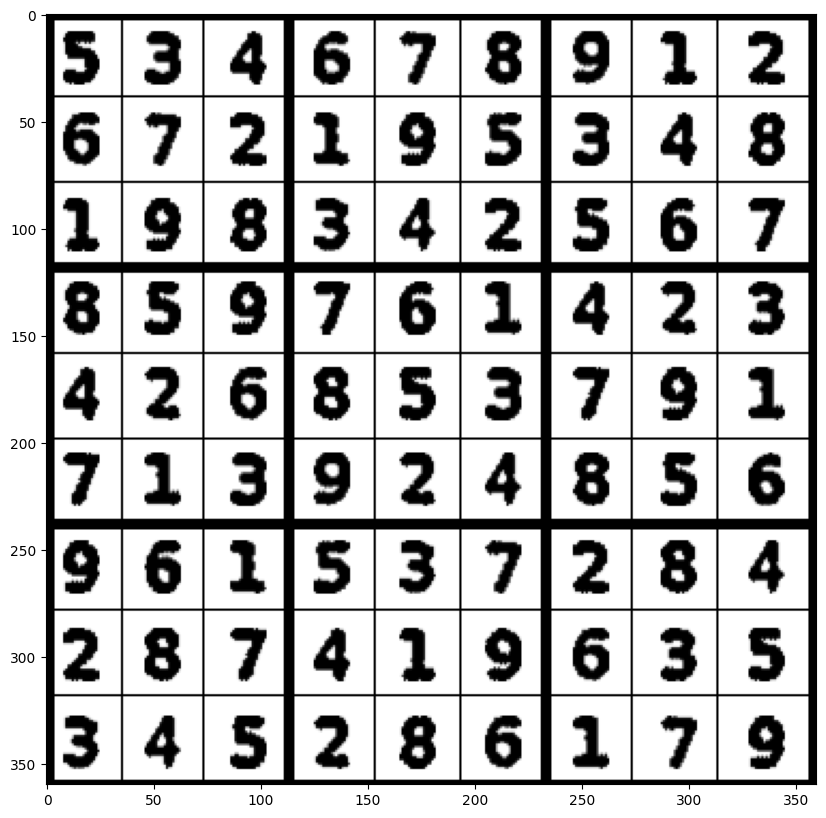

In [74]:
import random
solved_sudoku_image = np.zeros(digits_only.shape, np.uint8) # np.copy(sudoku_bin)
table = solved_sudoku_table
for yi in range(len(table)):
    for xi in range(len(table[0])):
        (x, y), (w, h) = yx_points[yi][xi], avg_dims

        label = table[yi][xi]
        digits_of_that_label = [d for d, l in zip(digits, labels) if l == label]
        digit = cv2.resize(digits_of_that_label[random.randint(0, len(digits_of_that_label)-1)], dsize=avg_dims[::-1])
        solved_sudoku_image[x:x+avg_dims[0], y:y+avg_dims[1]] = digit

for x, thichness in zip([1, 35, 73, 113, 153, 193, 233, 273, 313, 358], [3, 1, 1, 3, 1, 1, 3, 1, 1, 3]):
    cv2.line(solved_sudoku_image, pt1=[x, 0], pt2=[x, 360], color=[255], thickness=thichness)

for y, thichness in zip([0, 38, 78, 118, 158, 198, 238, 278, 318, 360], [3, 1, 1, 3, 1, 1, 3, 1, 1, 3]):
    cv2.line(solved_sudoku_image, pt1=[0, y], pt2=[360, y], color=[255], thickness=thichness)

plt.imshow(solved_sudoku_image, cmap='binary')

# Result

This approach contains a quick unpainfull solution to the recognition of the digits. Let's see the pros and cons of this approach.
Pros:
*   Simpler to implement. Clustering the digits can be done in one line of code.
*   Will work for any font and size, as long as it is consistent across the puzzle.
*   Very fast execution time

Cons:
*   It will not work for a sudoku puzzle that does not contain all 9 different digits/symbols (can be tweaked to understand how many different symbols we have using the Elbow technique)
*   The correct/exact sudoku puzzle and its solution is not known. Only the image representation is correct.